# Opdracht Regressie


De bedoeling van regressie is om op basis van een getraind model voorspellingen te doen van continue waarden.
Concreet komt het er op neer dat er een verband gezocht wordt tussen één of meerdere features en een zekere output variabele y. Dit verband is een (multidimensionale) curve van de vorm $y = \theta_n x_n + ... \theta_1 x_1 + \theta_0$. De vector X is de set van features en de set van $\theta$'s noemen we de parameters.

De doelstellingen van deze opdracht zijn:
- Data kunnen inlezen en verwerken met de pandas library.
- Eenvoudige statistische analyses uitvoeren op de data met als doel het detecteren van de consistenties van de data en het kunnen inschatten van de samenhang tussen de verschillende features en de output variabele.  
- Correct kunnen opsplitsen van de data in een training set en test set.
- Weten hoe je data normaliseert.
- Trainen van een regressiemodel.
- Kunnen evalueren van het getrainde regressiemodel via verschillende metrics zoals MAE en de $R^2$-score.
- Feature engineering toepassen: manueel of automatisch extra (hogere orde features) toevoegen.
- Kunnen detecteren van overfitting en underfitting.
- L1 en L2 regularisatie toepassen om te regelen tussen overfitting en underfitting.

In [1]:
%matplotlib inline
import datetime
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML libraries inladen

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Voor statistische data visualisatie
import seaborn as sns; sns.set(color_codes=True)

## 1. Dieet

Een dame was vriendelijk genoeg om een tijdje bij te houden hoeveel ze at, welke beweging ze deed enz. om te zien wat de impact was op haar gewicht. Meestal lette ze niet op wat ze at ze probeerde enkel meer calorieen te verbruiken dan dat ze innam. 

Een overzicht van de features:  

|      feature      | Description | 
|------------|-----|
| weight_oz | Total weight in ounces (target) |
| calories | approximate calories consumed on that date. Calorie counts were taken for each food based on nutritional information and rounded up to the nearest 50 to facilitate easy record keeping. Where nutritional information was not available, calorie counts were estimated from previous experience and best guesses of ingredients and comparison to meals with available nutritional information. |
| cals_per_oz | calories per ounce - calories for that day divided by weight in ounces |
| five_donuts | day where main meal was bag of five jam donuts, 1 = TRUE, 0 = FALSE |
| walk | day included at least one brisk walk of over 20 minutes, 1 = TRUE, 0 = FALSE |
| run | day included at one short run of 2.5 miles, 1 = TRUE, 0 = FALSE |
| wine | day finished with at least one large glass of wine when not accompanied by other fluids, 1 = TRUE, 0 = FALSE |
| prot | day involved what would be considered a high protein diet, 1 = TRUE, 0 = FALSE |
| weight | signifies day during period of weight-based exercise; includes rest days as part of period, 1 = TRUE, 0 = FALSE |



De bedoeling is om via meervoudige regressie zo betrouwbaar mogelijk het gewicht in ounces te voorspellen op basis van de calorie-inname en de activiteiten die deze persoon heeft gedaan op een bepaalde dag

In [2]:
# Dataset vanuit een csv bestand inlezen in een pandas dataframe.
dataset = pd.read_csv('diet_data.csv')

In [3]:
# Eerste rijen van de dataset
dataset.head()

,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,weight_oz
0,1950.0,0.72,1.0,1.0,0.0,0.0,0.0,0.0,2726.0
1,2600.0,0.96,1.0,0.0,0.0,0.0,0.0,0.0,2696.0
2,2500.0,0.92,1.0,1.0,0.0,0.0,0.0,0.0,2704.0
3,1850.0,0.68,1.0,1.0,0.0,1.0,0.0,0.0,2704.0
4,2900.0,1.09,1.0,1.0,0.0,0.0,0.0,0.0,2664.0


### Statistische vooranalyse

- Geef een samenvattende tabel met beschrijvende centrum- en spreidingswaarden via de describe funtie van pandas.
- Ga na of de dataset ontbrekende waarden bevat. Indien wel mogen de kolommen met ontbrekende waarden verwijdert worden.
- Is er op het eerste zicht sprake van uitschieters? Niettegenstaande dit voor multidimensionele gecorreleerde data niet volledig opgaat mag je bij deze opdracht uitschieters aanzien als featurewaarden die meer dan 5 standaardafwijkingen rond het gemiddelde gelegen zijn.
- Maak een correlatie heatmap. Welke features lijken het meest invloed te hebben op de kwaliteitsscore? Zijn er features die onderling sterk gecorreleerd zijn. Als je 5 features zou willen weglaten, welke zouden dit zijn? Verklaar waarom. Bij deze vraag is de verklaring belangrijk.
- Maak een pairplot, bekijk deze aandachtig en formuleer enkele conclusies. Zijn er verbanden te leggen tussen wat je ziet op de pairplot en op de correlatie heatmap?

In [4]:
# samenvattende tabel met met beschrijvende centrum- en spreidingswaarden
dataset.describe()

,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,weight_oz
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,3045.588505,1.132743,0.465694,0.720240,0.224411,0.306945,0.129528,0.403668,2690.379364
std,1208.424134,0.449687,0.459572,0.422030,0.384903,0.423114,0.318260,0.452039,35.085993
min,1400.000000,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000
25%,2189.319900,0.810000,0.000000,0.256817,0.000000,0.000000,0.000000,0.000000,2662.000000
50%,2600.000000,0.965000,0.377903,1.000000,0.000000,0.000000,0.000000,0.111308,2689.000000
75%,3709.285216,1.371081,1.000000,1.000000,0.347050,0.793181,0.000000,1.000000,2720.250111
max,7550.000000,2.810000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2768.000000


In [5]:
# ontbrekende waarden
nan = dataset.loc[dataset.isna().any(axis=1)]
if len(nan.values) > 0:
    dataset.dropna()

print("er zijn %s ontbrekende waardes zoals de tabel aantoond:" % ("" if (len(nan.values) > 0) else "geen"))
nan.head()

er zijn geen ontbrekende waardes zoals de tabel aantoond:


,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,weight_oz


In [6]:
# Weglaten van de uitschieters:
# Normaal gezien alleen maar doen als je weet dat de uitschieters het gevolg zijn van 
# inconsistenties of fouten.
from scipy import stats

applicable = ['calories', 'weight_oz']

dataset = dataset[(np.abs(stats.zscore(dataset[applicable])) < 5).all(axis=1)]
dataset.describe()

,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,weight_oz
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,3045.588505,1.132743,0.465694,0.720240,0.224411,0.306945,0.129528,0.403668,2690.379364
std,1208.424134,0.449687,0.459572,0.422030,0.384903,0.423114,0.318260,0.452039,35.085993
min,1400.000000,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000
25%,2189.319900,0.810000,0.000000,0.256817,0.000000,0.000000,0.000000,0.000000,2662.000000
50%,2600.000000,0.965000,0.377903,1.000000,0.000000,0.000000,0.000000,0.111308,2689.000000
75%,3709.285216,1.371081,1.000000,1.000000,0.347050,0.793181,0.000000,1.000000,2720.250111
max,7550.000000,2.810000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2768.000000


In [7]:
# aangezien de target rechtsreeks af te leiden valt uit de feature cals_per_oz moet deze verwijdert worden uit de dataset.
dataset = dataset.drop('cals_per_oz', axis=1)

<AxesSubplot:>

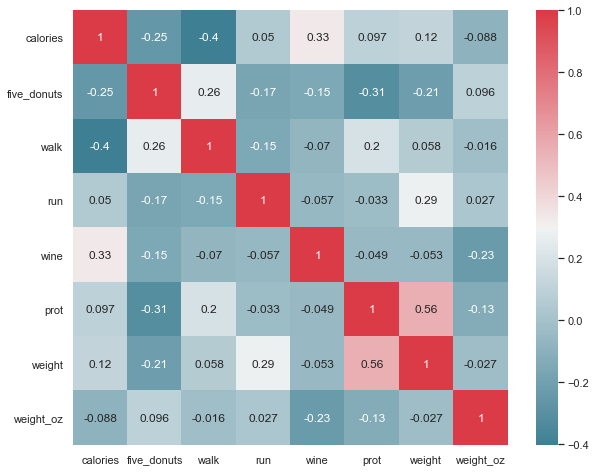

In [8]:
# Lineaire correlatie tussen de features - heatmap
for col in dataset.columns[1:-1]:
    dataset = dataset[(dataset[col] == 0) | (dataset[col] == 1)]

corr = dataset.corr()

# Visualiseer de onderlinge correlatiecoëfficiënten
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, annot=True)

# prot en weight lijken gecorreleerd te zijn, dit kan zijn door een hogere proteine inname voor en na het trainen.

# wat zou ik weglaten van features?
# - weight omvat ook rest days, dus we kunnen niet zeker zijn of het effectief een dag is met weight training
# - wine, prot en five_donuts kunnen we weglaten sinds we de calories al weten na een dag, dus hebben deze een mindere impact

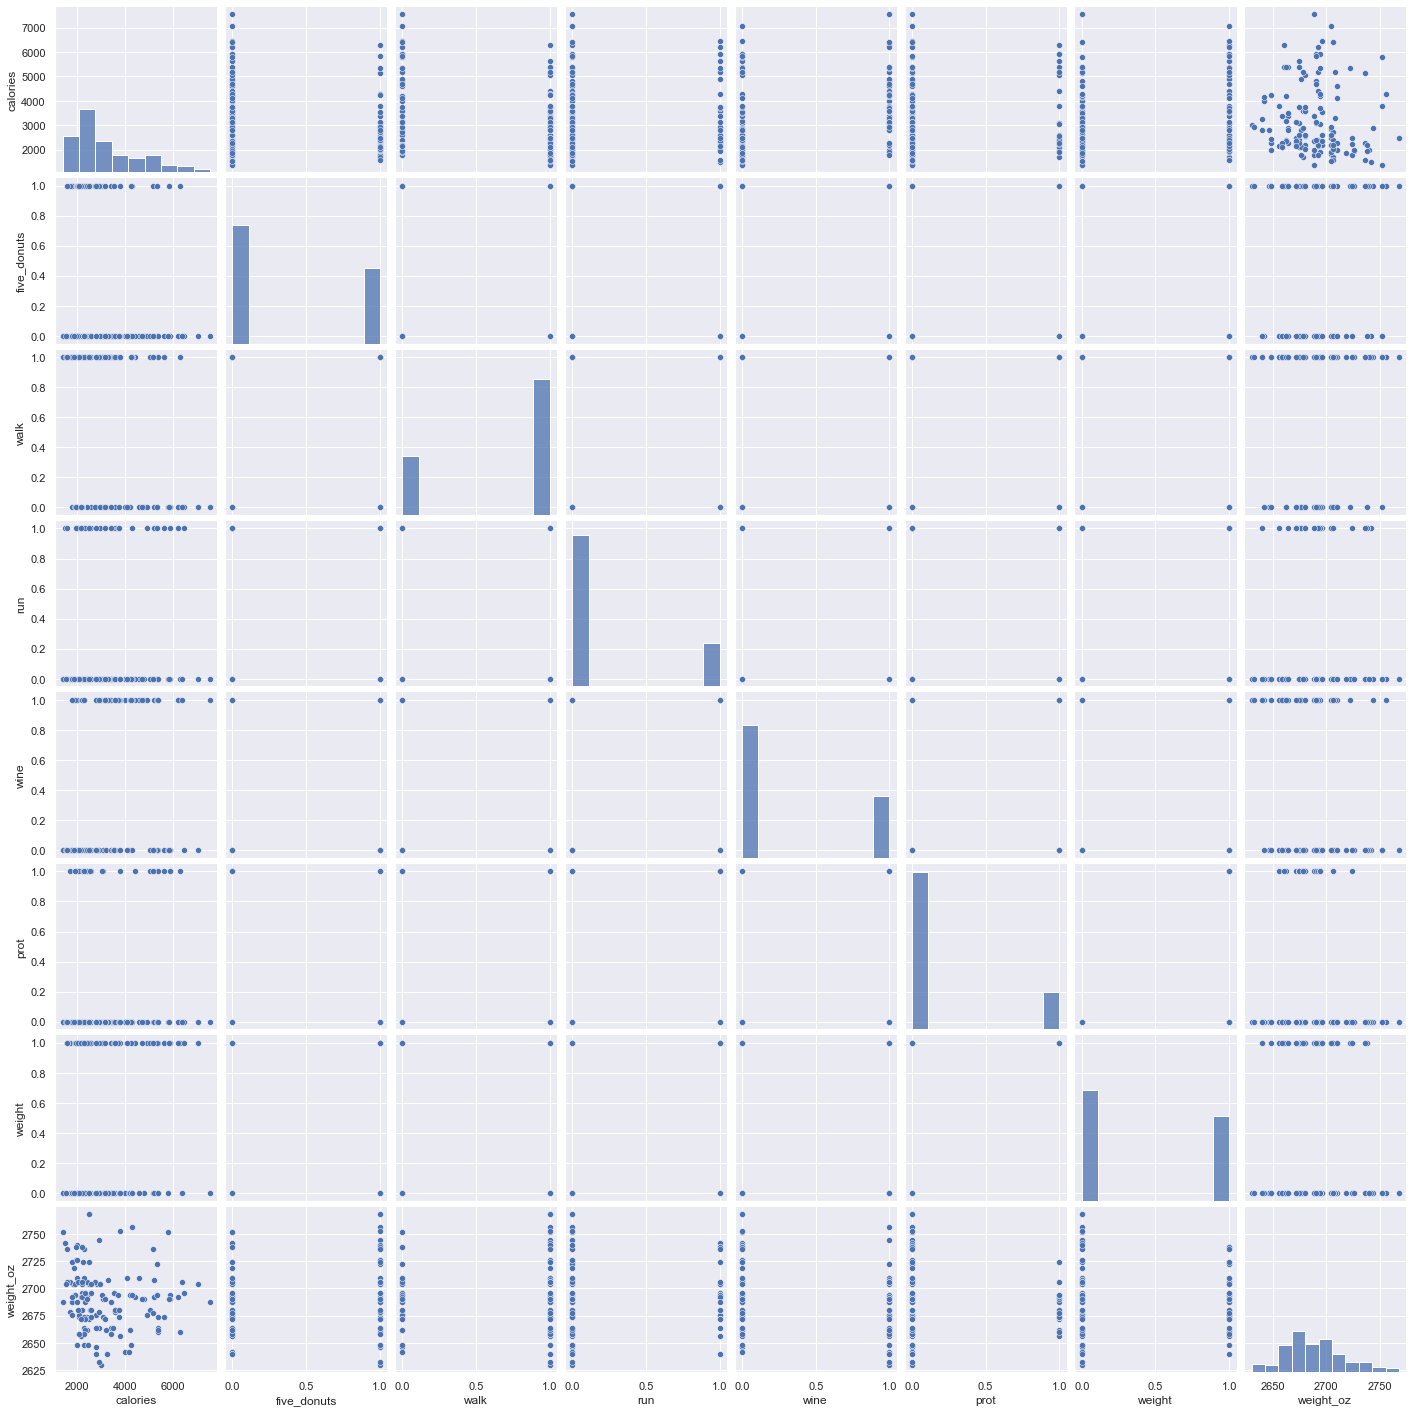

In [9]:
# Pairplot (=scatterplot). (Dit kan wat tijd vragen om te genereren)
# Formuleer conclusies
sns.pairplot(dataset)

#Je kan zien bij prot en weight dat weight 1 is als prot 1 is, er is geen weight 0 met prot 1, dit kan verklaren waarom deze opd e heatmap zo sterk correleren.

### Opsplitsen van de dataset

Splits de dataset op in features X en targets y. Vervolgens kan je de dataset opsplitsen in een training set en een test set. Gebruik hiervoor de functie train_test_split van Sklearn (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Zorg dat er 30 procent van de dataset in de test set terecht komt.

Normaliseer de training set en de test set met een standardscaler. Probeer later ook met een robustscaler.
Verklaar wat het verschil is tussen de standardscaler en de robustscaler.
De labels hoeven niet genormaliseerd te worden.

In [10]:
# Dataset opsplitsen in features en target
x  = (dataset.drop('weight_oz', axis=1, inplace=False)).values
y = dataset[['weight_oz']].values

In [11]:
# Opsplitsen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

<AxesSubplot:>

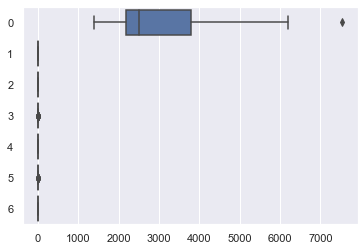

In [12]:
sns.boxplot(data=X_train, orient='h')

In [13]:
# Normaliseren van de training set en de test set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Het veschil tussen de 2 scalers is dat bij de standardscaler het gemiddelde op 0 wordt gelegd, en alles schommelt rond dit punt. Ook is de standaard afwijking op 1 gezet, dit zorgt voor een meer uniforme schaal van data. Bij robust scaling wordt er geen rekening met uitschieters gehouden, en kan er ook geen exact dezelfde schaal voor alles gegarandeerd worden. Robust scaling gebruikt wel minder data bij het bepalen van de nieuwe scale en heeft een grotere min max range dan bij een effectieve min-max scaling.")

Het veschil tussen de 2 scalers is dat bij de standardscaler het gemiddelde op 0 wordt gelegd, en alles schommelt rond dit punt. Ook is de standaard afwijking op 1 gezet, dit zorgt voor een meer uniforme schaal van data. Bij robust scaling wordt er geen rekening met uitschieters gehouden, en kan er ook geen exact dezelfde schaal voor alles gegarandeerd worden. Robust scaling gebruikt wel minder data bij het bepalen van de nieuwe scale en heeft een grotere min max range dan bij een effectieve min-max scaling.


<AxesSubplot:>

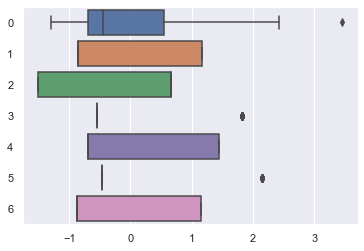

In [14]:
sns.boxplot(data=X_train_scaled, orient='h')

## Trainen van het regressiemodel

Train een regressiemodel via linear_model.LinearRegression(). Print vervolgens de coëfficiënten van het model. 

In [15]:
# Trainen van het regressiemodel
lregmodel = linear_model.LinearRegression()
lregmodel.fit(X_train_scaled, y_train)

LinearRegression()

In [16]:
# print de coëfficiënten en de intercept van het model
print("coefs: %s\n" % lregmodel.coef_[0])
print("intercept: %s" % lregmodel.intercept_[0])

coefs: [ 2.7577606  -0.72133877  1.13492875 -0.75427752 -7.38714973 -4.45390636
 -1.63983347]

intercept: 2691.7730253049995


### Testen en voorspellen

Evalueer het regressiemodel op basis van de MAE, MSE en de $R^2$-score. Gebruik hiervoor de test set. Formuleer een aantal conclusies uit deze scores.

In [17]:
# Evaluatie van het model via de MAE, MSE en de R2-score
from sklearn import metrics
y_predicted = lregmodel.predict(X_test_scaled)

MAE = metrics.mean_absolute_error(y_test, y_predicted)
MSE = metrics.mean_squared_error(y_test, y_predicted)
RSS = metrics.r2_score(y_test, y_predicted)

print("MAE", MAE)
print("MSE", MSE)
print("R-squared Score", RSS)

print(f"\nde gemiddelde afwijkende waarde van het huidige model is {round(MAE, 2)} en de gemiddelde afwijkende waarde van de gemiddelde kwadratische afwijking is {round(MSE, 2)}. Aan de R^2-score zien we dat ons huidige model {round(RSS*100, 2)}% van de afwijkingen kan verklaren")

MAE 20.020750548485477
MSE 696.551822023116
R-squared Score -0.07673969985949225

de gemiddelde afwijkende waarde van het huidige model is 20.02 en de gemiddelde afwijkende waarde van de gemiddelde kwadratische afwijking is 696.55. Aan de R^2-score zien we dat ons huidige model -7.67% van de afwijkingen kan verklaren


Wat is haar gewicht indien ze op een dag:  
2550.0 calories consumeert aan 0.82 calories per ounce, ze 5 donuts eet, ze niet gaat wandelen maar wel gaat lopen, ze wijn drinkt, niet aan het proteine dieet doet maar wel gewichtheft?
									

In [18]:
# Voorspelling van het gewicht.
x_new = scaler.fit_transform([[2550.0, 1, 0, 1, 1, 0, 1]])
y_predicted = lregmodel.predict(x_new)
print("de voorspelde waarde is %s kg" % round(y_predicted[0][0] * 0.0283495))

de voorspelde waarde is 76 kg


### Modeloptimalisatie
Probeer de performantie van het model te verbeteren. Zorg er met andere woorden voor dat de MAE en de MSE verlaagd worden en de $R^2$ score toeneemt.
Mogelijke opties zijn:
- Toevoegen van hogere orde features (manueel). Motiveer waarom je bepaalde hogere orde features zou gebruiken. Kijk hiervoor bijvoorbeeld naar de pairplot of de correlatie heatmap (ga op zoek naar niet-lineariteiten).
- Extra features afleiden uit de bestaande features.
- Toepassen van regularisatie via Ridge regression en Lasso regression. Ga telkens op zoek naar een goede waarde voor alpha. 
- Ga telkens na of er overfitting over underfitting optreedt. Doe dit door de performantie op de training set te vergelijken met de performantie op de test set. 
- Voeg automatisch hogere orde features toe via sklearn.preprocessing.PolynomialFeatures. Ga niet hoger dan 3de of 4de orde. Het aantal features neemt namelijk exponentiëel toe met de orde met als gevolg dat het model niet meer binnen een aanneembare tijd te trainen valt.

Motiveer telkens de gemaakte keuze en evalueer het model met de test set. Wat is de beste performantie die je haalt? **Bespreek het eindresultataat**.

In [19]:
from sklearn.preprocessing import PolynomialFeatures

# Adding higher order features
degree = 3

poly = PolynomialFeatures(degree)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print('X_train_poly dimension: ',X_train_poly.shape)
print('X_test_poly dimension: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=0.0001,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))

# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.01,tol=0.01,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      

      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))

# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train))

X_train_poly dimension:  (95, 120)
X_test_poly dimension:  (41, 120)
R2 score op test set via L2:  -658.4889906879166
R2 score op training set via L2:  0.5139818262581131
R2 score op test set via L1:  -43.42916033617706
R2 score op training set via L1:  0.4950016294095052


C:\Users\marie.dewitte\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17141.002215456883, tolerance: 813.9035825701387
  model = cd_fast.enet_coordinate_descent(


<div style="color:blue;">
Hoe hoger de orde van de features, hoe beter de modellen scoren op de training set, maar hoe slechter ze voorspellen op de test set.
Er is telkens sprake van underfitting. Deze features zijn onvoldoende om een goede voorspelling te doen van het gewicht. 
</div>

## 2. Lego

In het bestand *lego.csv* vind je een dataset met gegevens over lego sets en de prijs waaraan ze verkocht worden. Deze dataset is opgebouwd aan de hand van lego.com
Bedoeling is om een regressiemodel te vinden dat een zo accuraat mogelijke voorspelling kan doen van de prijs voor een bepaalde lego set aan de hand van de verschillende features zoals de bedoelde leeftijdscategorie, het aantal reviews,...

De verschillende features omvatten:

|      feature      | Description | 
|------------|-----|
| ages | de leeftijdscategorie waar de lego set voor bedoeld is |
| list_price | De prijs waar de lego set voor verkocht wordt |
| num_reviews | het aantal reviews op de website van lego  |
| piece_count | het aantel deeltjes dat de lego set uit bestaat |
| play_star_rating | de rating die de set krijgt op play star |
| prod_id | de id van de lego set|
| review_difficulty | de moeilijkheidsgraad |
| val_star_rating | value for money rating|
| country | in welk land de set verkocht werd |

De te voorspellen variabele (target) is 'list_price'


**Opdracht:**

- Controleer de dataset op inconsistenties: ontbrekende waarden, foutieve en extreme waarden

- Vooranalyse: visualiseer de prijs van de lego set aan de hand van de moeilijkheid, bijvoorbeeld via boxplots (https://seaborn.pydata.org/generated/seaborn.boxplot.html). Welke graad van moeilijkheid kost het meest en welke het minst? Visualiseer ook de prijs aan de hand van de leeftijdscategorie. Zijn er categorieen die opvallend duurder of goedkoper zijn?

- Pas one-hot encoding toe op de features ages, review_difficulty, theme_name en country. Zo worden categorische variabelen omgezet naar numerieke one-hot variabelen. Meer info over one-hot encoding is te vinden op https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b.

- Splits op in features en targets en maak vervolgens een training set en test set aan. Zorg ervoor dat er 100 samples in de test set zitten.

- Normaliseer de features. Categorische variabelen hoeven niet genormaliseerd te worden. Baseer je op de histogrammen om te beslissen welke normalisatie je zal toepassen (Standardscaler, MinMaxscaler of Robustscaler). De MinMaxscaler laat one-hot variabelen onveranderd.

- Train een regressiemodel

- Test het getraind model op de test set

- Doe optimalisaties en hyperparameter tuning om de performantie van het model (op de test set) te verhogen. Maak een grafiek van de r²-score in functie van de regularisatieparameter alpha.

- Bespreek het finaal bekomen model. Wat is de R²-score? Wat is de betekenis ervan? Wat zegt de bekomen MAE?

- Zijn er features die je mag weglaten? Met andere woorden, zijn er overbodige features? Argumenteer.

- Voorspel de prijs voor een legoset, bedoeld voor 16+, met 108 reviews een piece count van 4784 stukjes, met een play_star_rating van 4.3, prod_id 75252, review_difficulty 3.8, val_star_rating van 3.4 en verkocht in belgie. 



In [20]:
# Uitwerking opdracht lego
dataset = pd.read_csv('lego.csv')
dataset.head()

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_id,review_difficulty,theme_name,val_star_rating,country
0,6-12,29.99,2.0,277.0,4.0,75823.0,Average,Angry Birds™,4.0,US
1,6-12,19.99,2.0,168.0,4.0,75822.0,Easy,Angry Birds™,4.0,US
2,6-12,12.99,11.0,74.0,4.3,75821.0,Easy,Angry Birds™,4.1,US
3,12+,99.99,23.0,1032.0,3.6,21030.0,Average,Architecture,4.3,US
4,12+,79.99,14.0,744.0,3.2,21035.0,Challenging,Architecture,4.1,US


In [21]:
dataset.describe()

,list_price,num_reviews,piece_count,play_star_rating,prod_id,val_star_rating
count,12261.000000,10641.000000,12261.000000,10486.000000,1.226100e+04,10466.000000
mean,65.141998,16.826238,493.405921,4.337641,5.983675e+04,4.228960
std,91.980429,36.368984,825.364580,0.652051,1.638115e+05,0.660282
min,2.272400,1.000000,1.000000,1.000000,6.300000e+02,1.000000
25%,19.990000,2.000000,97.000000,4.000000,2.103400e+04,4.000000
50%,36.587800,6.000000,216.000000,4.500000,4.206900e+04,4.300000
75%,70.192200,13.000000,544.000000,4.800000,7.092200e+04,4.700000
max,1104.870000,367.000000,7541.000000,5.000000,2.000431e+06,5.000000


In [22]:
# drop missing values
print(dataset.shape)
dataset.dropna(inplace=True)
dataset.shape

(12261, 10)


(10162, 10)

<AxesSubplot:xlabel='list_price', ylabel='review_difficulty'>

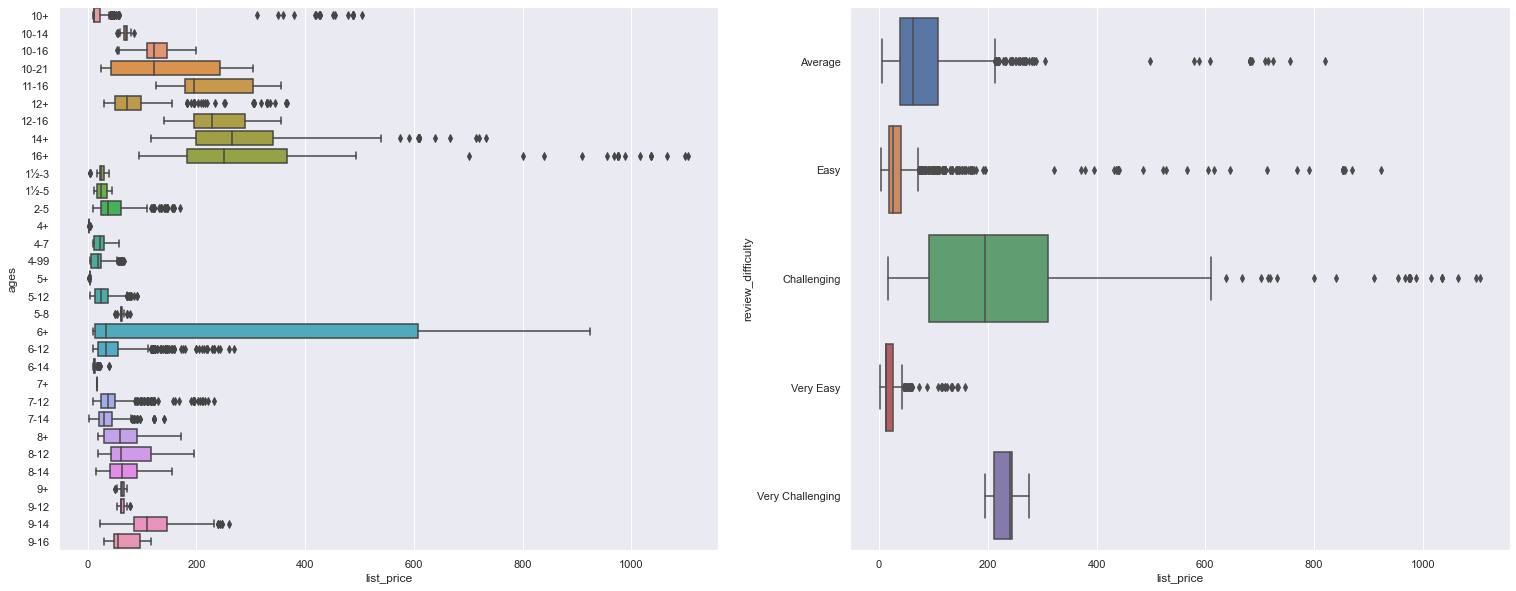

In [23]:

fig, axs = plt.subplots(1,2, figsize=(26,10))
sns.boxplot(x='list_price', y='ages', data=dataset.sort_values('ages'), ax=axs[0])
sns.boxplot(x='list_price', y='review_difficulty', data=dataset, ax=axs[1])

De challenging difficulty is meer gespreid, maar de very easy category is gemiddeld de goedkoopste. Beide very difficult en challenging zijn relatief duurder. Het valt ook op dat de sets voor leeftijden tussen 12 en 16 jaar duurder zijn dan de rest.

In [24]:
#Pas one-hot encoding toe op de features ages, review_difficulty, theme_name en country. 
#Zo worden categorische variabelen omgezet naar numerieke one-hot variabelen. 
#Meer info over one-hot encoding is te vinden op

features = ['ages', 'country', 'theme_name']
dataset = pd.get_dummies(dataset, columns=features)
dataset

,list_price,num_reviews,piece_count,play_star_rating,prod_id,review_difficulty,val_star_rating,ages_10+,ages_10-14,ages_10-16,...,theme_name_NINJAGO®,theme_name_Power Functions,theme_name_Pteranodon Chase,theme_name_SERIOUS PLAY®,theme_name_Speed Champions,theme_name_Star Wars™,theme_name_Stygimoloch Breakout,theme_name_THE LEGO® BATMAN MOVIE,theme_name_THE LEGO® NINJAGO® MOVIE™,theme_name_Technic
0,29.9900,2.0,277.0,4.0,75823.0,Average,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.9900,2.0,168.0,4.0,75822.0,Easy,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.9900,11.0,74.0,4.3,75821.0,Easy,4.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,99.9900,23.0,1032.0,3.6,21030.0,Average,4.3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,79.9900,14.0,744.0,3.2,21035.0,Challenging,4.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,36.5878,6.0,341.0,4.4,70609.0,Easy,4.2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12257,24.3878,8.0,217.0,4.1,70629.0,Easy,4.1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12258,24.3878,18.0,233.0,4.6,70607.0,Easy,4.5,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12259,12.1878,1.0,48.0,5.0,70628.0,Very Easy,5.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
#ordinaal encoderen van de review difficulty
mapper = {'Very Easy':1, 'Easy':2, 'Average': 3, 'Challenging': 4, 'Very Challenging': 5}

dataset['review_difficulty'].replace(mapper, inplace=True)
dataset

,list_price,num_reviews,piece_count,play_star_rating,prod_id,review_difficulty,val_star_rating,ages_10+,ages_10-14,ages_10-16,...,theme_name_NINJAGO®,theme_name_Power Functions,theme_name_Pteranodon Chase,theme_name_SERIOUS PLAY®,theme_name_Speed Champions,theme_name_Star Wars™,theme_name_Stygimoloch Breakout,theme_name_THE LEGO® BATMAN MOVIE,theme_name_THE LEGO® NINJAGO® MOVIE™,theme_name_Technic
0,29.9900,2.0,277.0,4.0,75823.0,3,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.9900,2.0,168.0,4.0,75822.0,2,4.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.9900,11.0,74.0,4.3,75821.0,2,4.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,99.9900,23.0,1032.0,3.6,21030.0,3,4.3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,79.9900,14.0,744.0,3.2,21035.0,4,4.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,36.5878,6.0,341.0,4.4,70609.0,2,4.2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12257,24.3878,8.0,217.0,4.1,70629.0,2,4.1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12258,24.3878,18.0,233.0,4.6,70607.0,2,4.5,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12259,12.1878,1.0,48.0,5.0,70628.0,1,5.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
# Splits op in features en targets en maak vervolgens een training set en test set aan. Zorg ervoor dat er 100 samples in de test set zitten.

X = dataset.drop('list_price', axis=1, inplace=False)
y = dataset['list_price'].values
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)

(10162, 96)


In [27]:
#We nemen best een MinMax scaling sinds we een groot aantal binaire features hebben.
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from time import time
from datetime import timedelta


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
#eerste test
lregmodel = LinearRegression()
lregmodel.fit(X_train_scaled, y_train)

y_predicted = lregmodel.predict(X_test_scaled)

score = metrics.r2_score(y_test, y_predicted)
score_train = metrics.r2_score(y_train, lregmodel.predict(X_train_scaled))
MAE = metrics.mean_absolute_error(y_test, y_predicted)
MSE = metrics.mean_squared_error(y_test, y_predicted)

print(f'''Standaard linear regression: 
training score: {score_train}
test score: {score}
MAE: {MAE}
MSE: {MSE}''')

Standaard linear regression: 
training score: 0.8670091261758326
test score: 0.9191476677911774
MAE: 14.850357499999996
MSE: 498.6755109821749


In [29]:
start = time()

poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_scaled, y_train)
X_test_poly = poly.transform(X_test_scaled)

lregmodel = LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)

y_predicted = lregmodel.predict(X_test_poly)

score = metrics.r2_score(y_test, y_predicted)
score_train = metrics.r2_score(y_train, lregmodel.predict(X_train_poly))

stop = time()

print(f'Calculation time: {timedelta(seconds=(stop - start))}')
print(f'''2de-graads functie:
test score: {score}
train score: {score_train}''')

Calculation time: 0:00:33.023303
2de-graads functie:
test score: -2.144334079141828
train score: 0.9940209768074457


Zoals te zien is, is er een zeer sterke overfitting op de 2de graadsfunctie. Dit is geen goed model voor de praktijk.

In [30]:
#ridge
b = 1e-3
tolerance = 5

alphas = np.arange(0, 5, b)
scores = []
scores_training = []

start = time()

for a in alphas:
    a = round(a, tolerance)
    lregmodel = Ridge(alpha=a, tol=pow(10,-tolerance), fit_intercept=False).fit(X_train_scaled, y_train)

    score = lregmodel.score(X_test_scaled, y_test)
    score_train = lregmodel.score(X_train_scaled, y_train)

    scores_training.append(score_train)
    scores.append(score)
stop = time()

best_score = 0
best_alpha = 0
best_train_score = 0

for i,j in enumerate(scores):
    if j > best_score:
        best_score = j
        best_train_score = scores_training[i]
        best_alpha = alphas[i]

print(f"Calculation time: {timedelta(seconds=(stop - start))}")
print(f'''best ridge regression model:
alpha: {best_alpha}
training score: {best_train_score}
test score: {best_score}''')


Calculation time: 0:00:44.498570
best ridge regression model:
alpha: 4.999
training score: 0.8634954309534886
test score: 0.9355159341397922


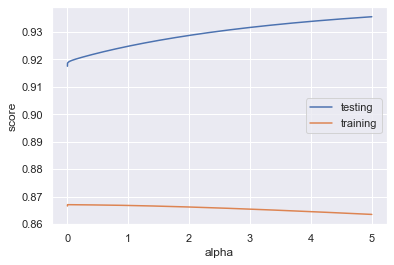

In [31]:
plt.plot(alphas, scores, label='testing')
plt.plot(alphas, scores_training, label='training')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()

In [32]:
#lasso
b = 1e-2
exp = 5

alphas = np.arange(0, 5, b)
scores = []
scores_training = []

start = time()

for a in alphas:
    a = round(a, exp)
    lregmodel = Lasso(alpha=a, tol=b, fit_intercept=False).fit(X_train_scaled, y_train)

    score = lregmodel.score(X_test_scaled, y_test)
    score_train = lregmodel.score(X_train_scaled, y_train)

    scores_training.append(score_train)
    scores.append(score)
stop = time()

print(f"Calculation time: {timedelta(seconds=(stop - start))}")
print(f'''best lasso regression model:
alpha: {alphas[scores.index(max(scores))]}
training score: {max(scores_training)}
test score: {max(scores)}''')

<ipython-input-32-311c925a348a>:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lregmodel = Lasso(alpha=a, tol=b, fit_intercept=False).fit(X_train_scaled, y_train)
C:\Users\marie.dewitte\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\marie.dewitte\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6589226.965142044, tolerance: 1504830.675231967
  model = cd_fast.enet_coordinate_descent(


Calculation time: 0:00:07.875371
best lasso regression model:
alpha: 0.01
training score: 0.8670212965748456
test score: 0.9191477838365272


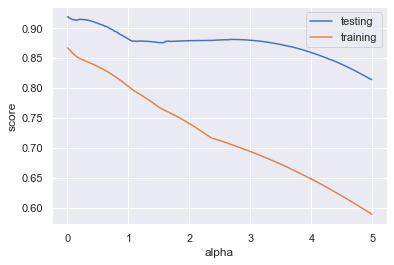

In [33]:
plt.plot(alphas, scores, label='testing')
plt.plot(alphas, scores_training, label='training')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()

In [34]:
#using best model
lregmodel = Lasso(alpha=0.01, tol=1e-5, fit_intercept=False).fit(X_train_scaled, y_train)
print("test score check:", lregmodel.score(X_test_scaled, y_test))

test score check: 0.9191311086590424


In [35]:
# Voorspel de prijs voor een legoset, bedoeld voor 16+, met 108 reviews een piece count van 4784 stukjes,
# met een play_star_rating van 4.3, prod_id 75252, review_difficulty 3.8, 
# val_star_rating van 3.4 en verkocht in belgie.

print(X.columns.size)
# print(X.columns[0:50])
sample = np.zeros(X.columns.size)
sample[X.columns.get_loc('num_reviews')] = 108
sample[X.columns.get_loc('piece_count')] = 4784
sample[X.columns.get_loc('play_star_rating')] = 4.3
sample[X.columns.get_loc('val_star_rating')] = 3.4
sample[X.columns.get_loc('prod_id')] = 75252
sample[X.columns.get_loc('review_difficulty')] = 4
mylist = ['ages_16+','theme_name_Architecture','country_BE']
for i in mylist:
    position = X.columns.get_loc(i)
    sample[position] = 1

sample = sample.reshape(1,-1)
sample = scaler.transform(sample)
#print(sample)
#sample_poly = poly.transform(sample)
sample_predicted = lregmodel.predict(sample)
print("De voorspelde prijs door het lineair model is: ", round(sample_predicted[0],2))



96
De voorspelde prijs door het lineair model is:  444.55
